## Procrustes analysis and PCA for Med image analysis 


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.spatial import procrustes
import sklearn
from sklearn import decomposition
import glob
import os
from PIL import Image
import numpy as np
import re
%matplotlib inline 

In [ ]:
# !apt install unzip
# !unzip '/content/Lung images from Bram.zip' -d '/content/data'
# # clear_output()

#### Data is stored in .pfs files, which contain points. Let's load them and plot ontop of image

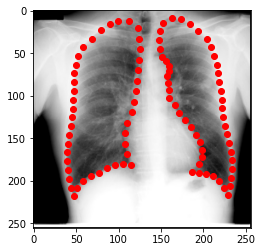

In [ ]:

def parseFile(fileName):
    """
    Dark magic function to load points into dict
    """
    objects = {}
    pattern = re.compile("[-+]?\d*\.\d+|\d+")
    points = []
    currentName = ''
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        if '  [Label=' in line:
            if currentName != '':
                objects[currentName] = points
            points = []
            currentName = line[9:-2]
        if line[0:4] == '  { ':
            splitted = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            points.append([float(splitted[0]), float(splitted[1])])
    objects[currentName] = points
    return objects
        
def readBothLungFields(fileName, scaler = 4):
    objects = parseFile(fileName)
    lungs = np.concatenate((np.asarray(objects['right lung']),
                            np.asarray(objects['left lung']))) / scaler
    return lungs

def readCompleteDatabase(dataFolder):
    database = {}
    files = os.listdir(dataFolder + '/Images/' )
    for file in files:
        caseName = os.path.split(file)[-1][:-4]
        im = Image.open(dataFolder + '/Images/' + caseName + '.bmp')
        pIm = np.array(im)[:, :, 0]
        databaseElement = {}
        databaseElement['points'] = readBothLungFields(dataFolder+"/scratch/landmarks/"+caseName+".pfs")
        databaseElement['image'] = im
        database[caseName] = databaseElement
    return database

database = readCompleteDatabase("data/Lung images from Bram/")
plt.scatter(database['JPCLN001']['points'][:, 0], database['JPCLN001']['points'][:, 1], c = 'r')
plt.imshow(database['JPCLN001']['image'], cmap='gray')

## **Task 1:**
- Normalize the scale, translation and rotation for the shape model before segmentation with active shape models. Do not forget to save scale factors in the database.
- Given: Database of lung shapes
- Do: fill in applyProcrustes function, which would normalize all shapes in database. . 



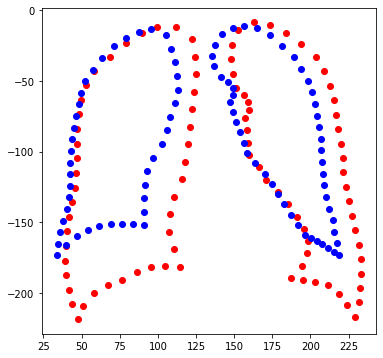

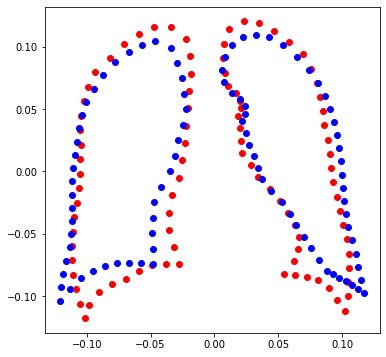

In [ ]:
def applyProcrustes(database):
  for i, key in enumerate(database):
    if i == 0:
      first_key = key
      continue
    elif i == 1:
      database[first_key]['points'], database[key]['points'], _ = procrustes(database[first_key]['points'], database[key]['points'])
      continue
    
    _, database[key]['points'], _ = procrustes(database[first_key]['points'], database[key]['points'])


plt.figure(1, figsize=(6, 6))
plt.scatter(database['JPCLN001']['points'][:, 0], -database['JPCLN001']['points'][:, 1], c = 'r')
plt.scatter(database['JPCLN003']['points'][:, 0], -database['JPCLN003']['points'][:, 1], c = 'b')
applyProcrustes(database)
plt.figure(2, figsize=(6, 6))
plt.scatter(database['JPCLN001']['points'][:, 0], -database['JPCLN001']['points'][:, 1], c = 'r')
plt.scatter(database['JPCLN003']['points'][:, 0], -database['JPCLN003']['points'][:, 1], c = 'b')

# Principal component analysis

## **Task 2 PCA:**
- Compute PCA for lung shape and generate different lung field variaitons
- Given: Database of lung shapes and applyProcrustes function from previous step
- Do: fill in generatePCA function, which would generate pca decomposition of lung shapes. Visualize some of them, using provided function


[[0, 94], [94, 188]]


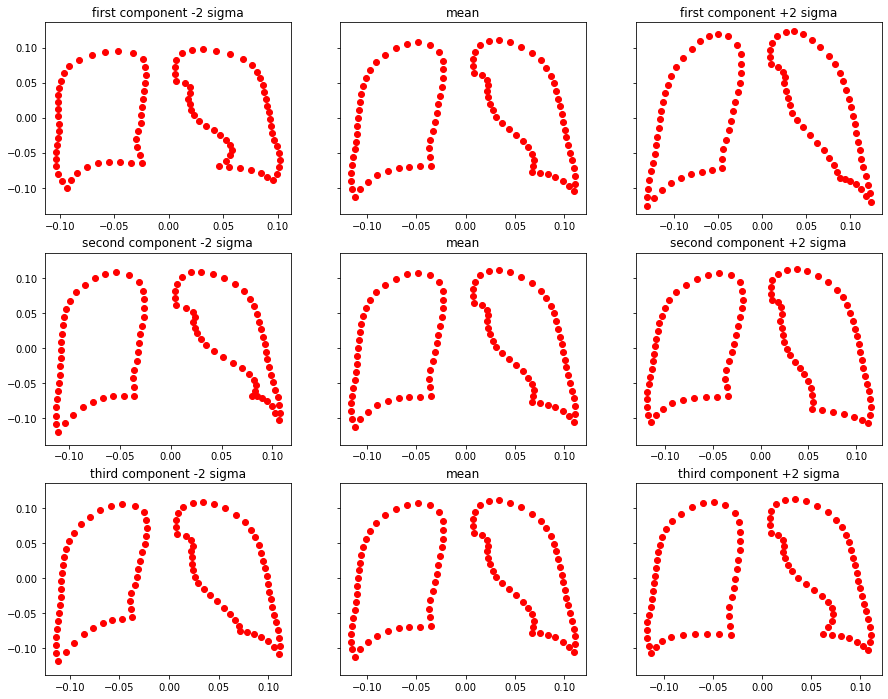

In [ ]:
def generatePCA(database):
  keys = list(database.keys())
  dataArray = np.zeros((len(keys), 2 * database[keys[0]]['points'].shape[0]))
  for i in range(0, len(keys)):
    dataArray[i, :] = database[keys[i]]['points'].flatten('F')
  X = dataArray
  
  pca = decomposition.PCA(n_components=3)
  pca.fit(X)
  return pca

def visualizePCAComponents(database, pca):
    keys = list(database.keys())
    dataArray = np.zeros((len(keys), 2 * database[keys[0]]['points'].shape[0]))
    for i in range(0, len(keys)):
        dataArray[i, :] = database[keys[i]]['points'].flatten('F')
        
    meanShape = np.mean(dataArray, axis = 0)
    size = [[0, int(meanShape.shape[0] / 2)], [int(meanShape.shape[0] / 2), meanShape.shape[0]]]
    print(size)
    # plt.figure(1)
    # print('variance = ', pca.explained_variance_)
    # print('explained_variance_ratio_ = ', pca.explained_variance_ratio_)
    # print('singular_values_ = ', pca.singular_values_)
    
    fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharey=True)

    axs[0][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[1][0]:size[1][1]], c = 'r')
    axs[0][0].title.set_text('first component -2 sigma')
    axs[0][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[0][1].title.set_text('mean')
    axs[0][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0][size[1][0]:size[1][1]], c = 'r')
    axs[0][2].title.set_text('first component +2 sigma')
    
    
    axs[1][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[1][0]:size[1][1]], c = 'r')
    axs[1][0].title.set_text('second component -2 sigma')
    axs[1][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[1][1].title.set_text('mean')
    axs[1][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[1]) * pca.components_[1][size[1][0]:size[1][1]], c = 'r')
    axs[1][2].title.set_text('second component +2 sigma')
    
    axs[2][0].scatter( meanShape[size[0][0]:size[0][1]] - 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] - 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[1][0]:size[1][1]], c = 'r')
    axs[2][0].title.set_text('third component -2 sigma')
    axs[2][1].scatter( meanShape[size[0][0]:size[0][1]], -meanShape[size[1][0]:size[1][1]], c = 'r')
    axs[2][1].title.set_text('mean')
    axs[2][2].scatter( meanShape[size[0][0]:size[0][1]] + 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[0][0]:size[0][1]], 
                      -meanShape[size[1][0]:size[1][1]] + 2 * np.sqrt(pca.explained_variance_[2]) * pca.components_[2][size[1][0]:size[1][1]], c = 'r')
    axs[2][2].title.set_text('third component +2 sigma')
    
    return

applyProcrustes(database)
pca = generatePCA(database)
visualizePCAComponents(database, pca)
    
